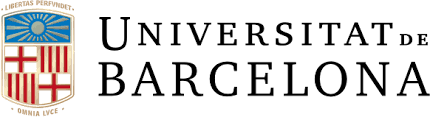

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training'
test_dir = '/content/drive/MyDrive/Testing'

In [4]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [5]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 4602 files for training.


In [6]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 1150 files for validation.


In [7]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


**Visualizacion de algunas imagenes**

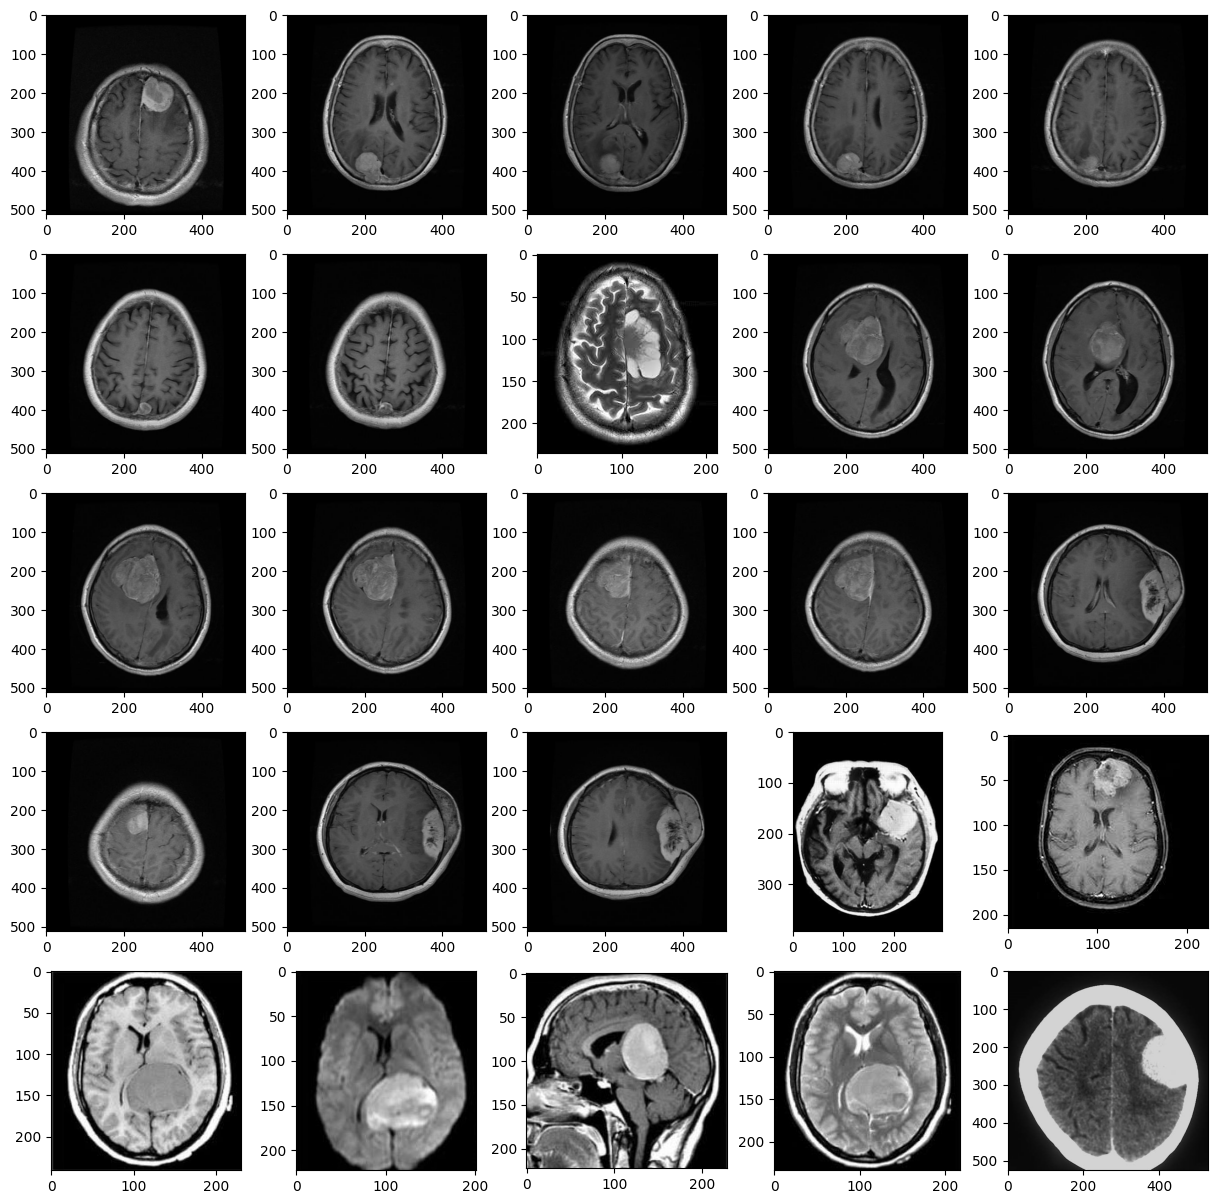

In [8]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Meningiomas'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training/meningioma'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [10]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [11]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

  ]
)

# Entrenamiento del Modelo

In [12]:
# Cracion del modelo con Redes Neuronales Convolucionales (CNN)
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    #layers.Dense(num_classes, name="outputs")
    layers.Dense(num_classes, activation='softmax', name="outputs")

])

In [13]:
# Compilar
#model.compile(optimizer='adam',
             # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             # metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [15]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNNv2.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True
)

In [16]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNN.h5" en el directorio actual
model.save("TFM_CNNv2.h5")

Epoch 1/15
144/144 [==============================] - 886s 2s/step - loss: 0.8939 - accuracy: 0.6280 - val_loss: 0.5810 - val_accuracy: 0.7722
Epoch 2/15
144/144 [==============================] - 128s 889ms/step - loss: 0.6067 - accuracy: 0.7566 - val_loss: 0.5135 - val_accuracy: 0.8078
Epoch 3/15
144/144 [==============================] - 126s 875ms/step - loss: 0.5139 - accuracy: 0.7951 - val_loss: 0.4060 - val_accuracy: 0.8470
Epoch 4/15
144/144 [==============================] - 130s 904ms/step - loss: 0.4784 - accuracy: 0.8138 - val_loss: 0.4112 - val_accuracy: 0.8487
Epoch 5/15
144/144 [==============================] - 130s 901ms/step - loss: 0.4149 - accuracy: 0.8414 - val_loss: 0.4250 - val_accuracy: 0.8461
Epoch 6/15
144/144 [==============================] - 126s 875ms/step - loss: 0.3894 - accuracy: 0.8492 - val_loss: 0.5196 - val_accuracy: 0.8348
Epoch 7/15
144/144 [==============================] - 127s 885ms/step - loss: 0.3474 - accuracy: 0.8655 - val_loss: 0.3742 - va

# Curvas de Rendimiento

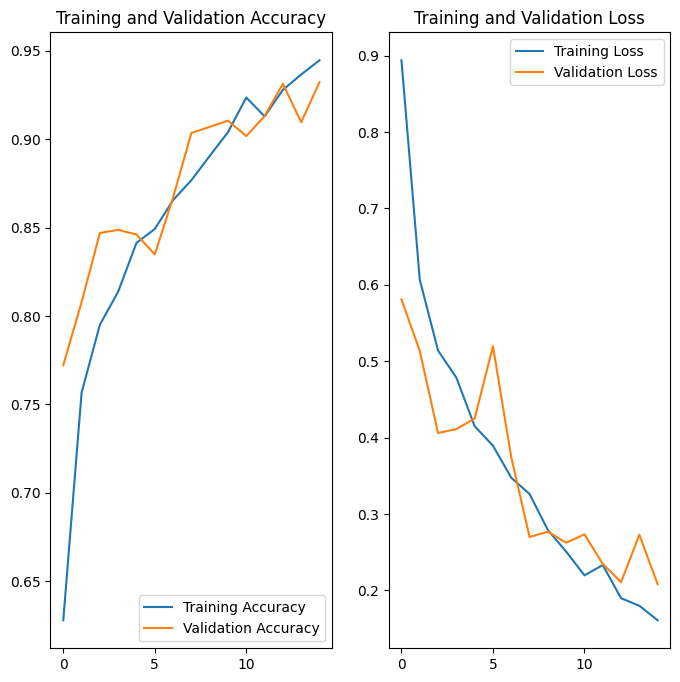

In [17]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluacion del Modelo

In [18]:
# Lectura del Set de Entrenamiento
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1351 files belonging to 4 classes.


**Predicciones**

In [19]:
#Predicciones en el set de Testing
predictions = model.predict(test_ds)
# Se usa tf.nn.softmax ya que se aplico padding en training y al ser un problema multiclase o multinomial
# prediction. Threfore, we used `CategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

43/43 [==============================] - 185s 3s/step


**Loss & Accuracy**

In [20]:
results = model.evaluate(test_ds)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



43/43 [==============================] - 12s 275ms/step - loss: 0.1791 - accuracy: 0.9371
Test Loss: 0.17912937700748444
Test Accuracy: 0.9370836615562439


**Matriz de Confusion**

In [21]:
# Create two numpy arrays to store labels of test data and prediction
# of respective image
y_test_actual = np.array([])
y_pred_actual = np.array([])

# Iterate over every batch and enter data in created numpy arrays
for x, y in test_ds:
    # Convert label tensor to numpy and concatenate
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))
    # Process prediction score and concatenate result
    predictions = model.predict(x)
    scores = tf.nn.softmax(predictions[:])
    y_pred = np.argmax(scores, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

1/1 [==============================] - 0s 148ms/step


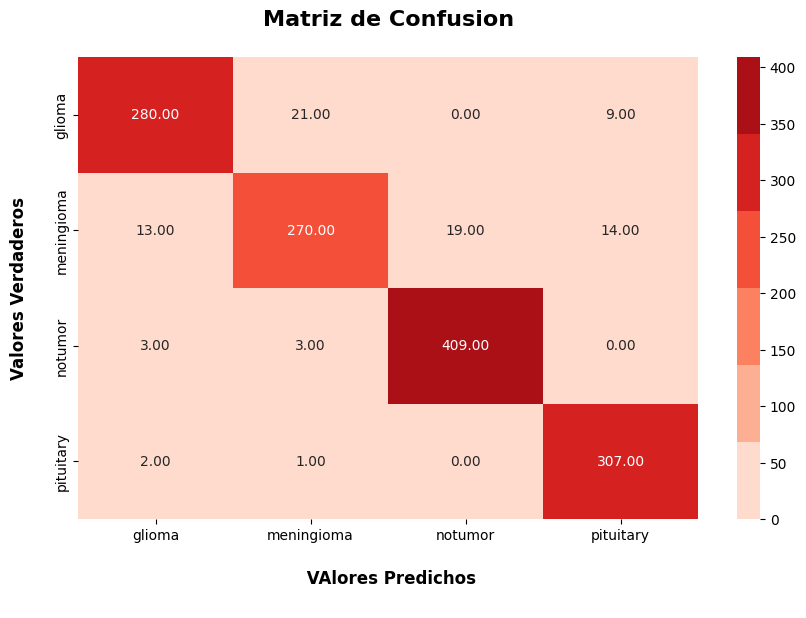

In [24]:
confusion = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(10,6))
fig = sns.heatmap(confusion, annot=True, fmt=".2f",cmap=cmap)

fig.set_title('Matriz de Confusion\n',
              fontdict={
                  "fontsize":16,
                  "fontweight": 'bold'
              })
fig.set_xlabel('\n VAlores Predichos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.set_ylabel('Valores Verdaderos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
plt.show()

# Informe de Clasificacion

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las etiquetas verdaderas y las predicciones en el conjunto de pruebas
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_pred.extend(np.argmax(predictions, axis=1))

# Obtener la información sobre las clases del conjunto de entrenamiento
class_names = class_names

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusion:")
print(cm)

# Obtener el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print("Informe de Clasificacion:")
print(report)



1/1 [==============================] - 0s 53ms/step
Matriz de Confusion:
[[280  21   0   9]
 [ 13 270  19  14]
 [  3   3 409   0]
 [  2   1   0 307]]
Informe de Clasificacion:
              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       310
  meningioma       0.92      0.85      0.88       316
     notumor       0.96      0.99      0.97       415
   pituitary       0.93      0.99      0.96       310

    accuracy                           0.94      1351
   macro avg       0.94      0.93      0.93      1351
weighted avg       0.94      0.94      0.94      1351



# Pruebas con Bulk Uploading

In [25]:
def test_model(model, test_dir, class_names):
    # Obtener la lista de nombres de archivo en el directorio de prueba
    file_names = os.listdir(test_dir)
    # Filtrar solo los nombres de archivo con extensión .jpg
    file_names = [file for file in file_names if file.lower().endswith('.jpg')]

    # Preprocesar las imágenes y realizar las predicciones
    for file_name in file_names:
        # Cargar la imagen y redimensionarla
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(test_dir, file_name),
            target_size=(img_height, img_width)
        )
        # Convertir la imagen a un arreglo numpy
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        # Expandir las dimensiones para que coincida con el formato de entrada del modelo
        img_array = tf.expand_dims(img_array, 0)
        # Preprocesar la imagen
        img_array = normalization_layer(img_array)
        # Realizar la predicción
        predictions = model.predict(img_array)
        scores = tf.nn.softmax(predictions)

        # Obtener las probabilidades de todas las clases
        probabilities = scores[0]

        # Mostrar la imagen, la clase predicha y las probabilidades
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagen: {}'.format(file_name))
        plt.show()

        print('Clases y Probabilidades:')
        for i, class_name in enumerate(class_names):
            probability = probabilities[i]
            print('{}: {:.2f}%'.format(class_name, probability * 100))
        print()






1/1 [==============================] - 0s 32ms/step


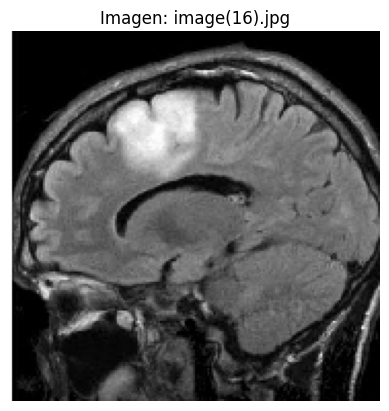

Clases y Probabilidades:
glioma: 47.51%
meningioma: 17.50%
notumor: 17.50%
pituitary: 17.49%

1/1 [==============================] - 0s 22ms/step


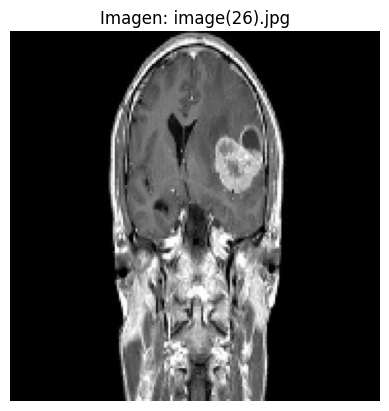

Clases y Probabilidades:
glioma: 47.50%
meningioma: 17.50%
notumor: 17.50%
pituitary: 17.49%

1/1 [==============================] - 0s 22ms/step


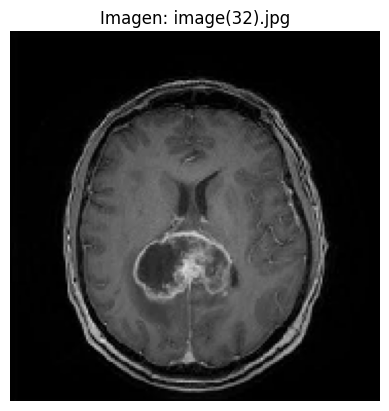

Clases y Probabilidades:
glioma: 47.50%
meningioma: 17.50%
notumor: 17.50%
pituitary: 17.49%



In [26]:
test_dir = '/content/drive/MyDrive/Patient File'

class_names = class_names

test_model(model, test_dir, class_names)
